<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

**Цель проекта - построить модель для прогнозирования заказов такси на следующий час** (значение метрики *RMSE* на тестовой выборке должно быть не больше 48).

Этапы проекта:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('https://github.com/valeria-khmelenko/practicum-projects/blob/main/taxi-demand-forecast/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df.isna().sum()

num_orders    0
dtype: int64

In [6]:
df.sort_index(inplace=True)

In [7]:
print(df.index.is_monotonic)

True


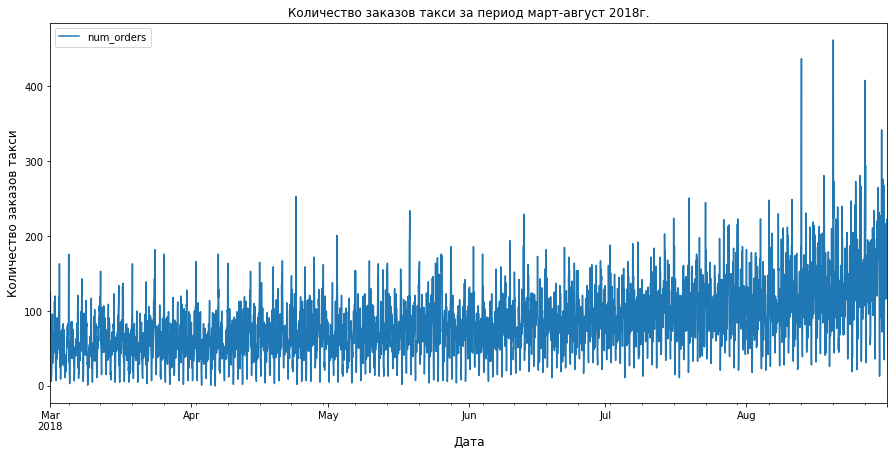

In [8]:
df = df.resample('1H').sum()
df.plot(figsize=(15,7))
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество заказов такси', fontsize=12)
plt.title('Количество заказов такси за период март-август 2018г.', fontsize=12)
plt.legend()
plt.show()

Промежуточный вывод: в результате подготовки данных, содержащих количество заказов такси за период с 01.03.2018г. по 31.08.2018г. в разбивке по 10 мин, датасет был проиндексирован по дате, отсортирован по возрастанию даты и ресемлирован до 1 часа.

## Анализ

Разложим временной ряд на трендовую, сезонную и остаточную составляющие:

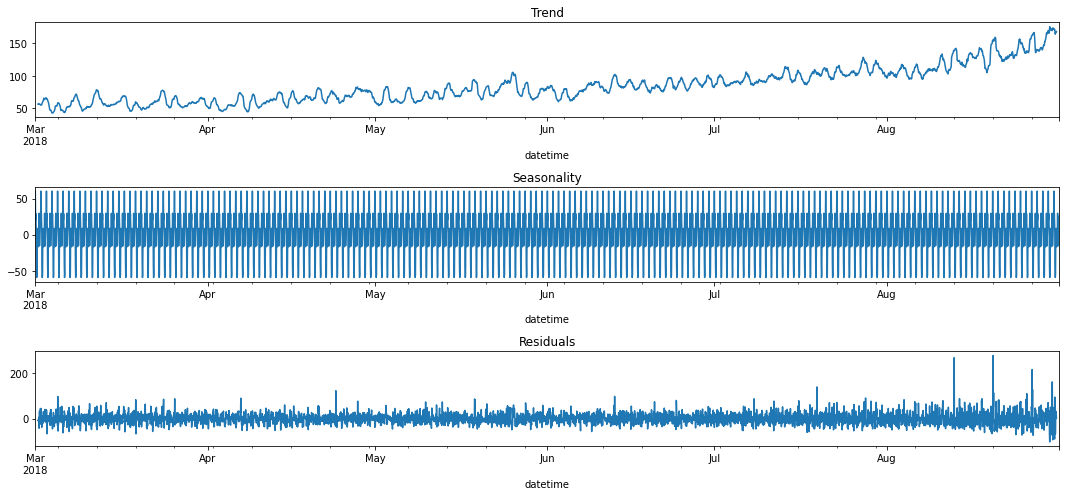

In [9]:
df_decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 7))
plt.subplot(311)
df_decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
df_decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
df_decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Промежуточный вывод:  исходя из данных графиков видно, что наблюдается восходящий тренд в ряде, также присутствует сезонность, характер которой определим позднее, в остатках видны выбросы.

Построим график сезонности на выборочных данных, чтобы оценить характер сезонности

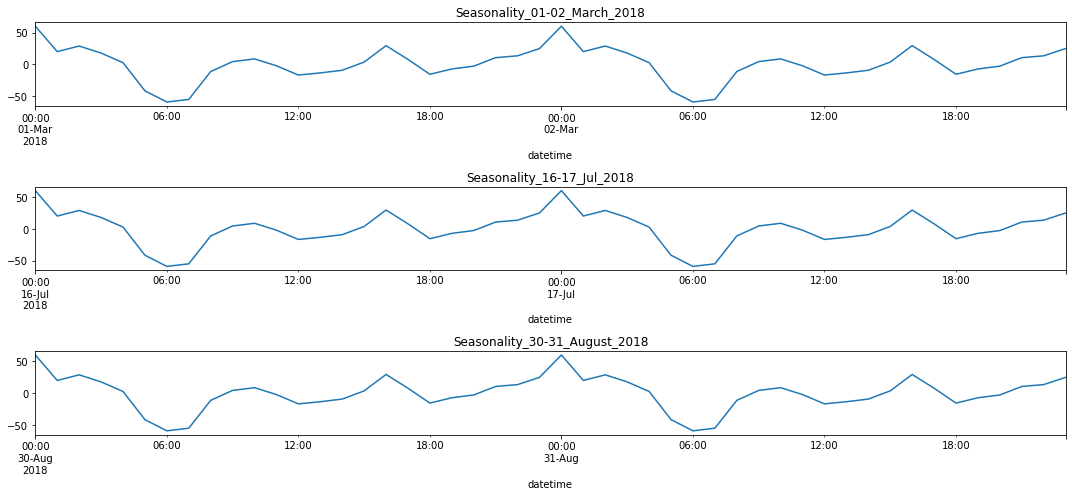

In [10]:
plt.figure(figsize=(15, 7))
plt.subplot(311)
df_decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca())
plt.title('Seasonality_01-02_March_2018')
plt.subplot(312)
df_decomposed.seasonal['2018-07-16':'2018-07-17'].plot(ax=plt.gca())
plt.title('Seasonality_16-17_Jul_2018')
plt.subplot(313)
df_decomposed.seasonal['2018-08-30':'2018-08-31'].plot(ax=plt.gca())
plt.title('Seasonality_30-31_August_2018')
plt.subplot(313)
plt.tight_layout()

Промежуточный вывод: сезонность имеет внутридневной характер: пик заказов приходится на полночь, наибольшее падение - на шесть утра. 

Оценим ряд на стационарность графическим методом

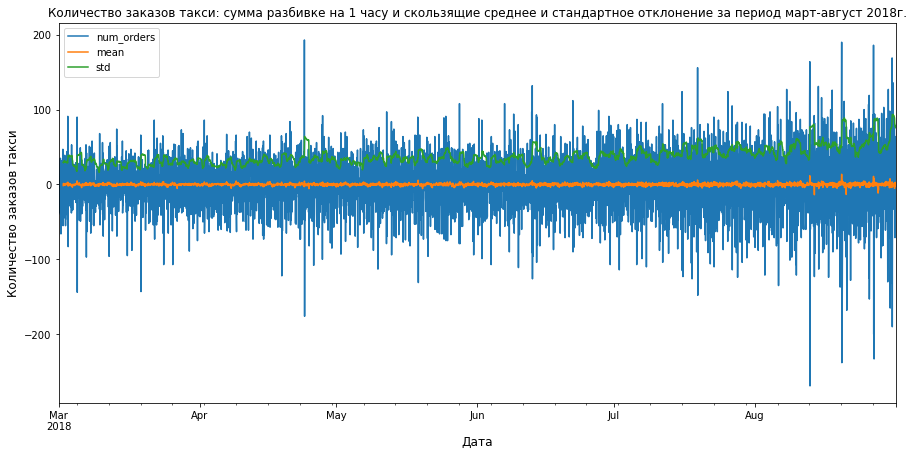

In [11]:
df_new = df - df.shift()
df_new['mean'] = df_new['num_orders'].rolling(24).mean()
df_new['std'] = df_new['num_orders'].rolling(24).std()
df_new.plot(figsize=(15,7))
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество заказов такси', fontsize=12)
plt.title('Количество заказов такси: сумма разбивке на 1 часу и скользящие среднее и стандартное отклонение за период март-август 2018г.', fontsize=12)
plt.legend()
plt.show()

Промежуточный вывод: исходя из данных графика можно сказать, что ряд стационарен (среднее и стандарное отклонения практически не меняются), однако стоит оценить станционарность более сторогими методами, например по критерию Дики-Фулера

Оценим стационарность ряда по критерию Дики-Фулера для ряда с трендом (Н0 - ряд не стационарный, Н1 - ряд стационарный)

In [12]:
DF_test = adfuller(x= df['num_orders'], regression = 'ct')
print('ADF Statistic: {}'.format(DF_test[0]))
print('p-value: {}'.format(DF_test[1]))
print('Critical values:')
for key, value in DF_test[4].items():
  print('\t {}: {}'.format(key, value))

ADF Statistic: -8.326521572379816
p-value: 1.2583924361803877e-11
Critical values:
	 1%: -3.960836041046122
	 5%: -3.4114917019432394
	 10%: -3.127639850914672


Промежуточный вывод: значение статистики лежит левее критических значений для всех указанных уровней значимости, поэтому гипотеза о нестационарности ряда отклоняется, ряд - стационарный, можем осущестить прогнозирование.

Добавим новые признаки в ряд и удалим пропущенные значения:

In [13]:
def make_features(df, max_lag, rolling_mean_size):

    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
    df['rolling_mean'] = df['num_orders'].shift(1).rolling(rolling_mean_size).mean()

make_features(df, 1, 24)

In [14]:
df.dropna(inplace=True)
df.head()

,num_orders,dayofweek,hour,lag_1,rolling_mean
datetime,,,,,
2018-03-02 00:00:00,90,4,0,58.0,56.833333
2018-03-02 01:00:00,120,4,1,90.0,55.416667
2018-03-02 02:00:00,75,4,2,120.0,56.875000
2018-03-02 03:00:00,64,4,3,75.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,56.958333


Вывод: в результате анализа данных временного ряда можно сделать вывод, что ряд имеет восходящий тренд с выраженной внутридневной сезонностью (с пиками в полночь и спадами в шесть утра), при этом ряд является стационарным, можем осуществить прогнозирование. Для этого в датасет добавили новые признаки (итого 4 нецелевых признака).

## Обучение

Разделим датасет на тренировочную и тестовую выборки согласно заданному условию (тестовая выборка - 10%)

In [15]:
train, test = train_test_split(df, test_size=0.1, shuffle=False)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


In [16]:
target_train = train['num_orders']
features_train = train.drop(columns='num_orders')
target_test = test['num_orders']
features_test = test.drop(columns='num_orders')

In [17]:
time_split = TimeSeriesSplit(n_splits=8)

Проведем поиск оптимальных параметров модели LinearRegression с помощью кроссвалидации на тренировочных данных

In [18]:
start_lin = time.time()

model_lin = LinearRegression()

score_lin = cross_val_score(model_lin,features_train, target_train, 
                         cv = time_split, 
                         n_jobs = -1, 
                         scoring = 'neg_root_mean_squared_error').mean()

print(f'''Значение метрики RMSE на обучающей выборке для LinearRegression''', -score_lin)

end_lin = time.time() - start_lin

Значение метрики RMSE на обучающей выборке для LinearRegression 31.34322751744601


Проведем поиск оптимальных параметров модели RandomForestRegressor с помощью кроссвалидации на тренировочных данных

In [19]:
start_rf = time.time()

model_rf = RandomForestRegressor()

parameters_rf = {'max_depth': [4, 6, 10],
                'n_estimators': [30, 50, 100]}

grid_rf = GridSearchCV(model_rf, parameters_rf, scoring = 'neg_root_mean_squared_error',  cv = time_split, n_jobs=-1)
grid_rf.fit(features_train, target_train)

print('Наименьшее значение RMSE в модели RandomForestRegressor равно {} \n при следующих гиперпараметрах: {}'
      .format(-grid_rf.best_score_, grid_rf.best_params_))

end_rf = time.time() - start_rf

Наименьшее значение RMSE в модели RandomForestRegressor равно 24.98266992448029 
 при следующих гиперпараметрах: {'max_depth': 10, 'n_estimators': 50}


Проведем поиск оптимальных параметров модели LGBMRegressor с помощью кроссвалидации на тренировочных данных

In [20]:
start_lgbm = time.time()

model_lgbm = LGBMRegressor()
parameters_lgbm = {'learning_rate': [0.1, 0.3, 0.5],
                'max_depth': [4, 6, 10],
                'n_estimators': [30, 50, 100]}

grid_lgbm = GridSearchCV(model_lgbm, parameters_lgbm, scoring = 'neg_root_mean_squared_error',  cv = time_split, n_jobs=-1)
model_lgbm = grid_lgbm.fit(features_train, target_train)

print('Наименьшее значение RMSE в модели LGBMRegressor равно {} \n при следующих гиперпараметрах: {}'
      .format(-grid_lgbm.best_score_, grid_lgbm.best_params_))

end_lgbm = time.time() - start_lgbm

Наименьшее значение RMSE в модели LGBMRegressor равно 24.521218350130646 
 при следующих гиперпараметрах: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50}


In [21]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'LGBMRegressor']
final = {'RMSE на обучении, кол-во заказов':[round(-score_lin, 2),
                                 round(-grid_rf.best_score_, 2),
                                 round(-grid_lgbm.best_score_, 2)],
        'Время обучения  модели, сек':[round(end_lin, 2),
                                       round(end_rf, 2),
                                       round(end_lgbm, 2)]}

data_final = pd.DataFrame(data=final, index=index)
display(data_final)

,"RMSE на обучении, кол-во заказов","Время обучения модели, сек"
LinearRegression,31.34,2.14
RandomForestRegressor,24.98,1.88
LGBMRegressor,24.52,1.71


Вывод: LGBMRegressor является наилучшей моделью с найденными оптимальными параметрами, т.к. показывает наименьшее значение RMSE и наименьшее время для обучения.

## Тестирование

Протестируем LGBMRegressor на тестовой выборке

In [22]:
model_lgbm_final = LGBMRegressor(max_depth=10, n_estimators=50, learning_rate=0.1)
model_lgbm_final.fit(features_train, target_train)
lgbm_predicted_test = model_lgbm_final.predict(features_test)
RMSE_lgbm_test_predicted = mean_squared_error(target_test, lgbm_predicted_test, squared=False)
print('RMSE модели LGBMRegressor на тестовой выборке', round(RMSE_lgbm_test_predicted, 2))

RMSE модели LGBMRegressor на тестовой выборке 44.19


Вывод: на тестовой выборке предложенная модель показывает значение RMSE приемлемое для условия задачи (не более 48)

Выведем график реальных и предсказанных значений финальной модели для визульного анализа

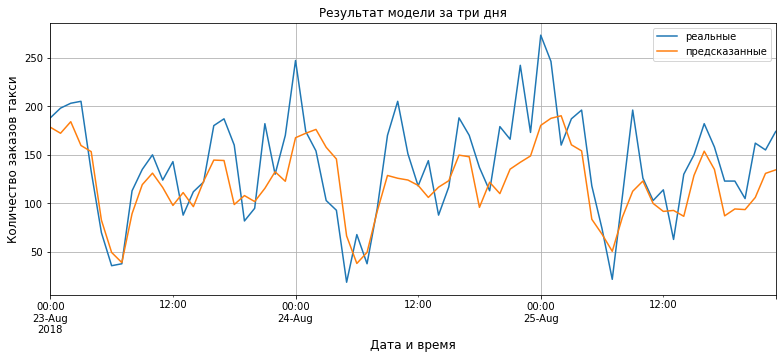

In [23]:
results = pd.DataFrame({'target': target_test,
                       'predicted': lgbm_predicted_test})

results['2018-08-23':'2018-08-25'].plot(figsize=(13,5))
plt.xlabel('Дата и время', fontsize=12)
plt.ylabel('Количество заказов такси', fontsize=12)
plt.title('Результат модели за три дня', fontsize=12)
plt.legend(['реальные', 'предсказанные'])
plt.grid(True)
plt.show()

Вывод: На графике видно, что модель удовлетворительно прогнозирует пиковые значения и для целей задачи (RMSE не более 48) эта модель удовлетворяет заданному критерию.

## Вывод

При реализации проекта были осуществлены следующие действия и сделаны следующие выводы:
1) в результате подготовки данных, содержащих количество заказов такси за период с 01.03.2018г. по 31.08.2018г. в разбивке по 10 мин, датасет был проиндексирован по дате, отсортирован по возрастанию даты и ресемлирован до 1 часа;<br/>
2) в результате анализа данных временного ряда был сделан вывод о том, что ряд имеет восходящий тренд с выраженной внутридневной сезонностью (с пиками в полночь и спадами в шесть утра), при этом ряд является стационарным, осуществлять прогнозирование имеет смысл. Для этого в датасет добавили новые признаки (итого стало 4 нецелевых признака);<br/>
3) в трех исследуемых моделях (LinearRegression, LGBMRegressor, RandomForestRegressor) найдены оптимальные параметры для последующего обучения и предсказания;<br/>
Наиболее подходящей моделью из трех исследованных является LGBMRegressor по критериям  качества предсказания (метрика RMSE < 48 на обучающей и тестовой выборках) и времени обучения.